In [302]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from data_tools import *
import mysql.connector

Se realiza la carga de los datos desde una DB remota a un Data Frame de Pandas para realizar un tratamiento inicial (Label Encoding para el target)

In [303]:
conn = mysql.connector.connect(user='ml_client', password='distsys_2023@',
                              host='129.159.106.139',
                              database='ml_project')

db_cursor = conn.cursor()

db_cursor.execute('SELECT * FROM `TABLE 1`')

table_rows = db_cursor.fetchall()

df = pd.DataFrame(table_rows)

In [304]:
# df = pd.read_csv('data/cancer_data.csv')
le = LabelEncoder()
df[1] = le.fit_transform(df[1])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,1,17.9900000,10.3800000,122.8000000,1001.0000000,0.1184000,0.2776000,0.3001000,0.1471000,...,25.3800000,17.3300000,184.6000000,2019.0000000,0.1622000,0.6656000,0.7119000,0.2654000,0.4601000,0.1189000
1,842517,1,20.5700000,17.7700000,132.9000000,1326.0000000,0.0847400,0.0786400,0.0869000,0.0701700,...,24.9900000,23.4100000,158.8000000,1956.0000000,0.1238000,0.1866000,0.2416000,0.1860000,0.2750000,0.0890200
2,84300903,1,19.6900000,21.2500000,130.0000000,1203.0000000,0.1096000,0.1599000,0.1974000,0.1279000,...,23.5700000,25.5300000,152.5000000,1709.0000000,0.1444000,0.4245000,0.4504000,0.2430000,0.3613000,0.0875800
3,84348301,1,11.4200000,20.3800000,77.5800000,386.1000000,0.1425000,0.2839000,0.2414000,0.1052000,...,14.9100000,26.5000000,98.8700000,567.7000000,0.2098000,0.8663000,0.6869000,0.2575000,0.6638000,0.1730000
4,84358402,1,20.2900000,14.3400000,135.1000000,1297.0000000,0.1003000,0.1328000,0.1980000,0.1043000,...,22.5400000,16.6700000,152.2000000,1575.0000000,0.1374000,0.2050000,0.4000000,0.1625000,0.2364000,0.0767800


In [305]:
y = df[1].values
df = df.drop(1, axis=1)
df = df.drop(0, axis=1)
df = df.dropna(axis=1)
X = df.values
(X.shape, y.shape)

((569, 30), (569,))

Se realiza un escalado de los parámetros en el rango de 0-1

In [306]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Comenzamos con el procedimiento de selección de características. La estrategia es determinar cuales son las mejores características para utilizar en los métodos de clasificación evaluando la "usabilidad" que poseen. En este caso, ya que la distribución de las muestras es aproximadamente una normal, el enfoque se desarrollará alrededor de esa idea.

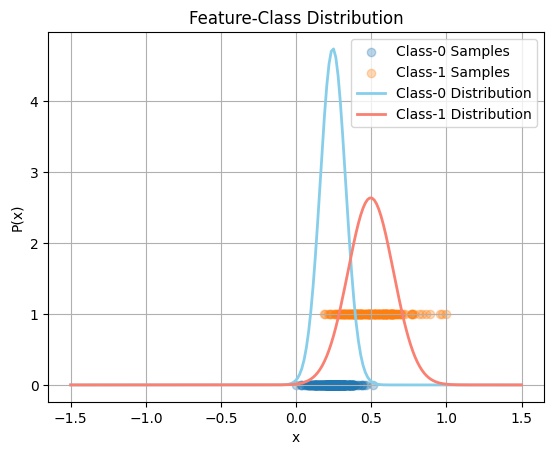

In [307]:
params = get_feature_distribution(X[:,0], y)

overlapping_error, mean_difference = feature_performance(X[:,0], y,
                        params['mu0'],
                        params['std0'],
                        params['mu1'], 
                        params['std1'],
                        plot=True)

Una vez que se obtienen los parámetros de las distribuciones a las que presuntamente pertenecen las muestras de cada clase (según la feature que se esté evaluando), se calcula la distancia que existe entre las medias y el grado de superposición que existe entre las distribuciones, que no es otra cosa que la suma del error alfa y beta en la mezcla de gaussianas.

In [308]:
overlapping_error, mean_difference

(67.72969457749745, 0.2516118310925949)

Esta idea nos permite visualizar y cuantificar el valor de cada feature en el conjunto de datos.

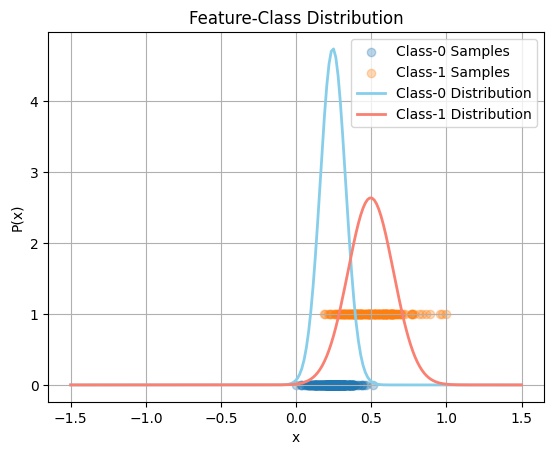

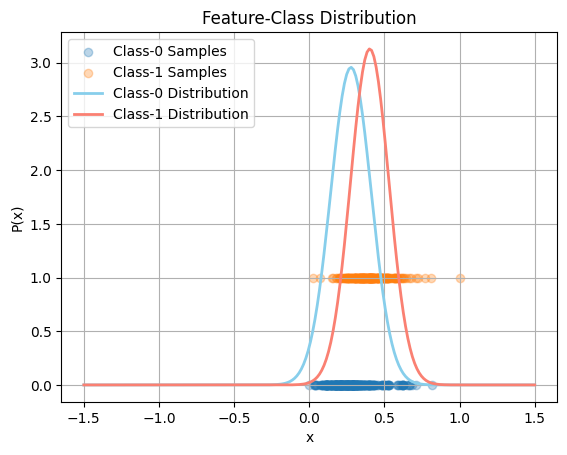

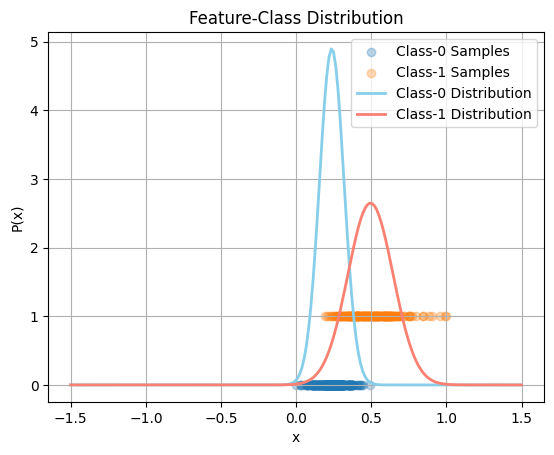

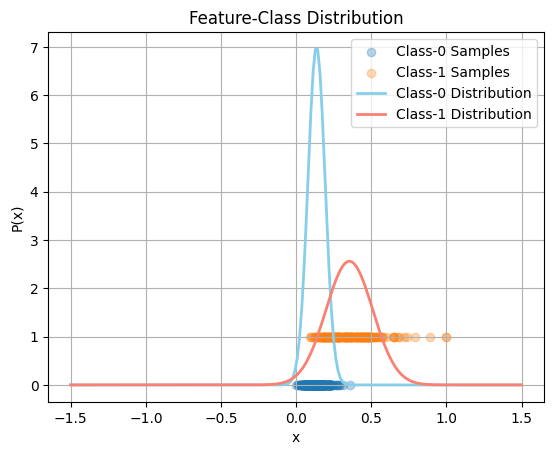

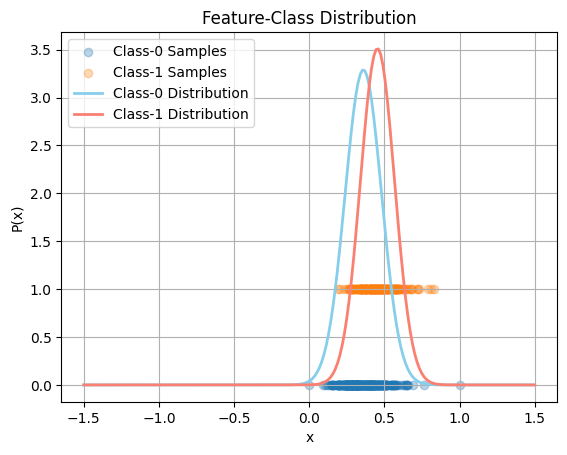

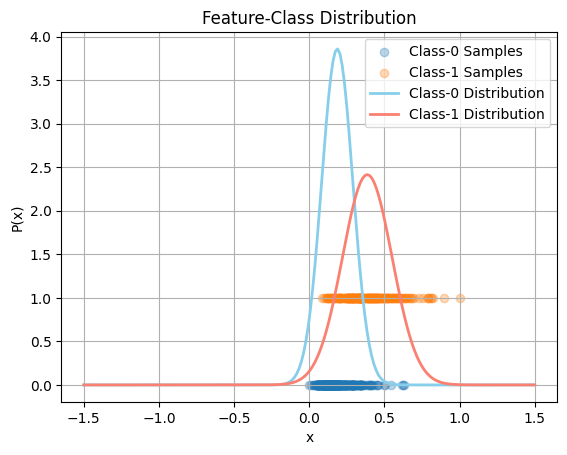

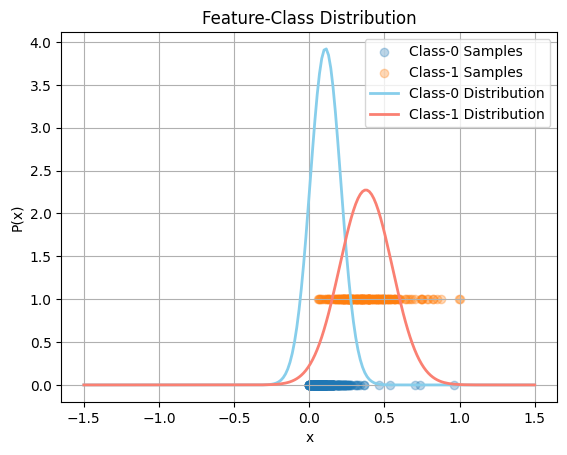

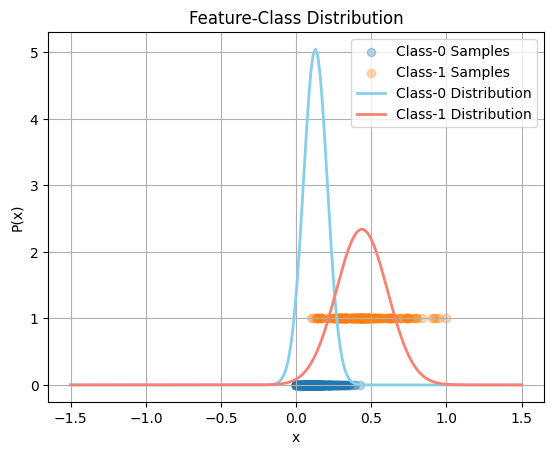

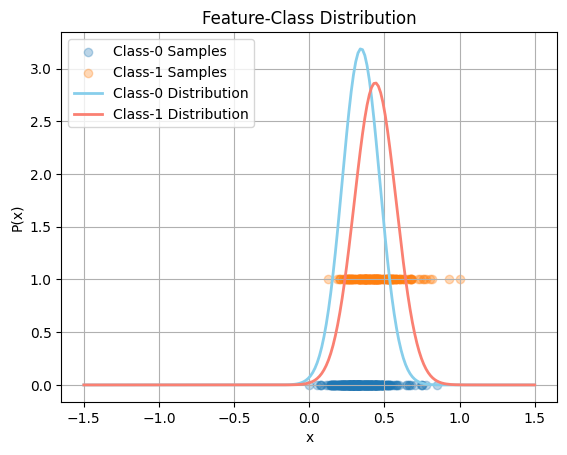

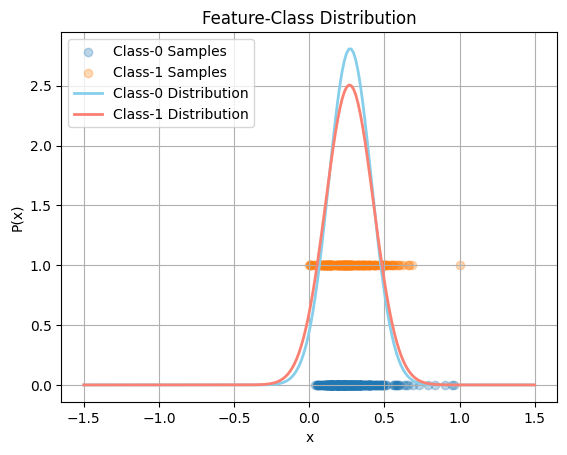

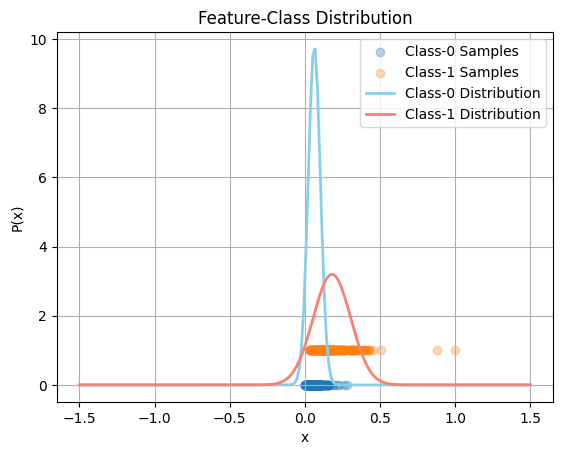

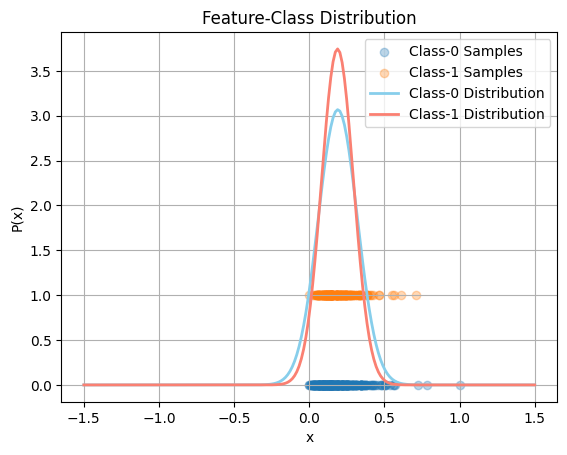

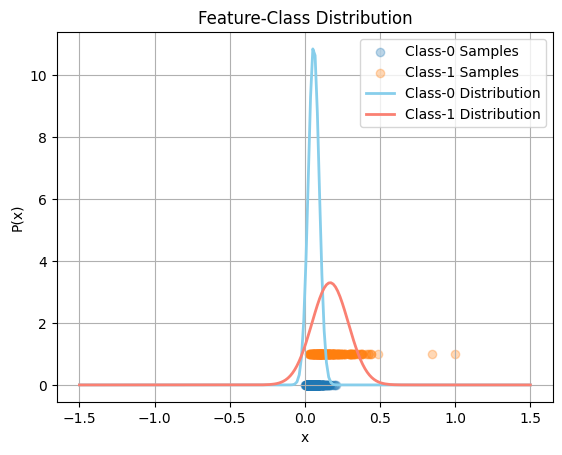

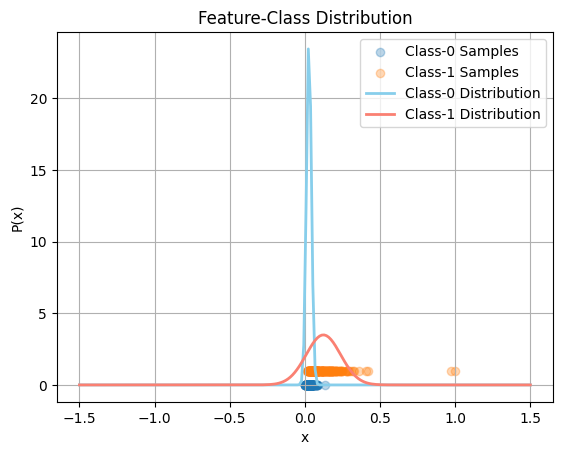

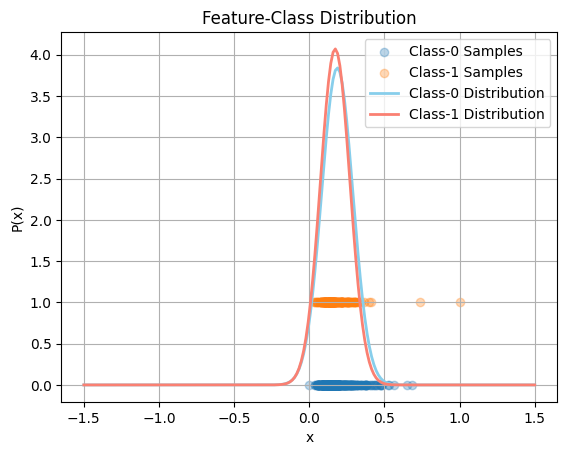

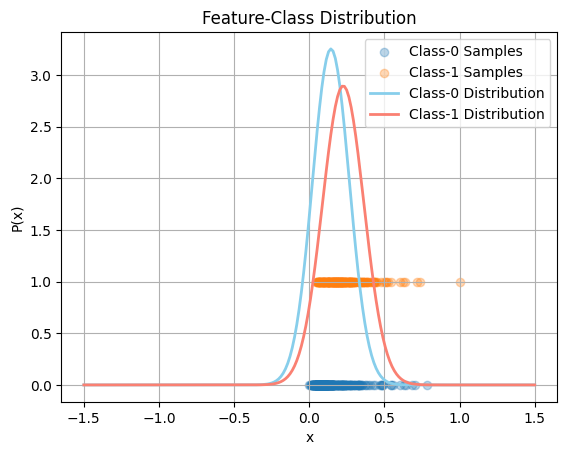

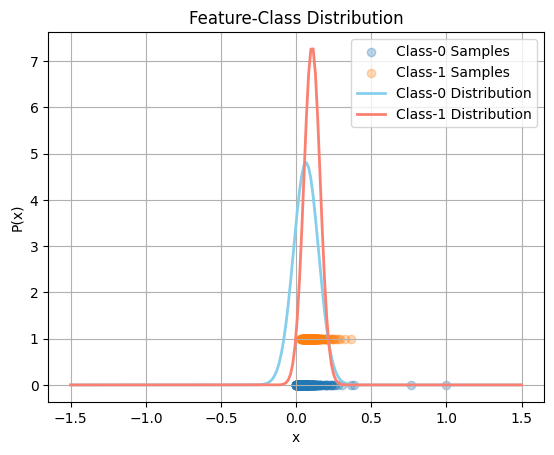

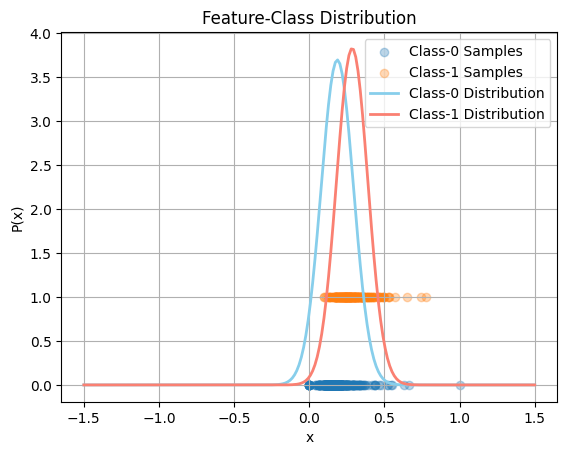

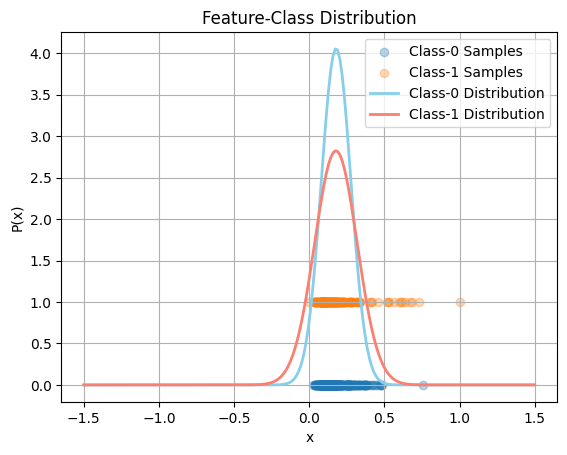

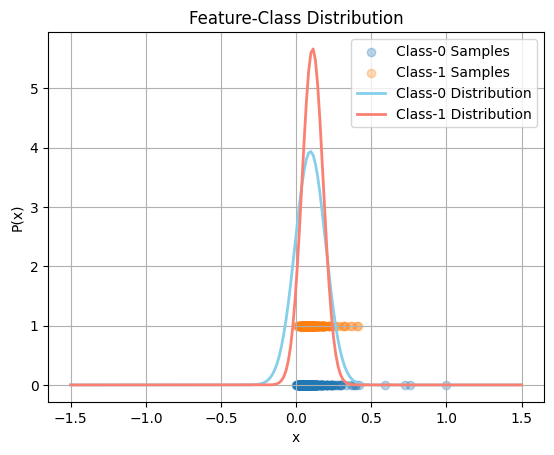

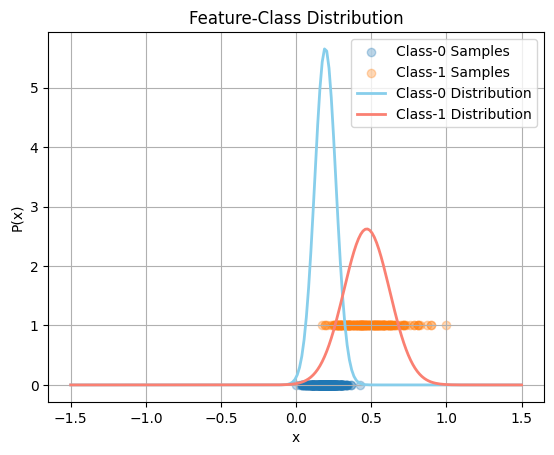

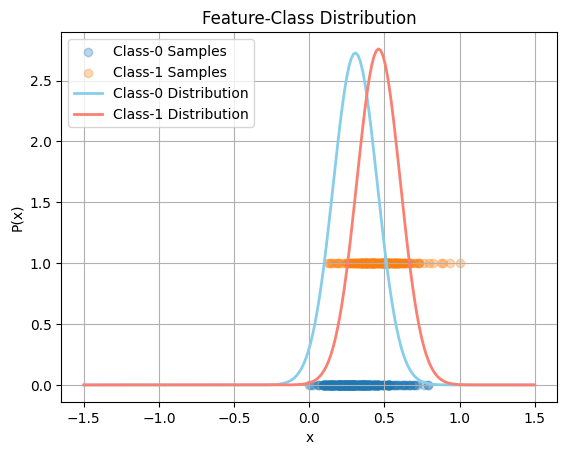

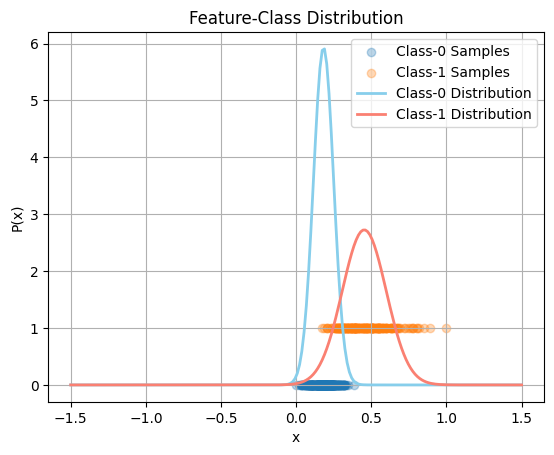

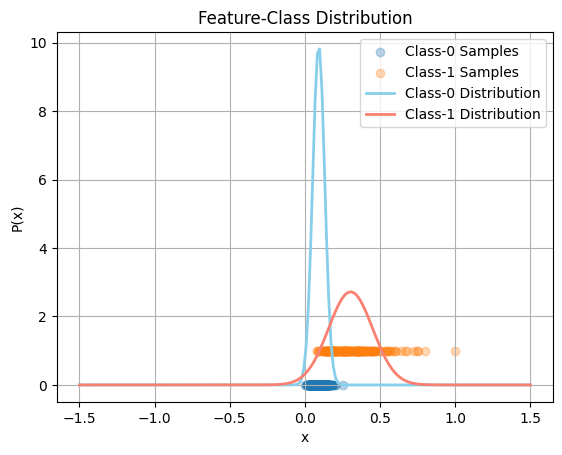

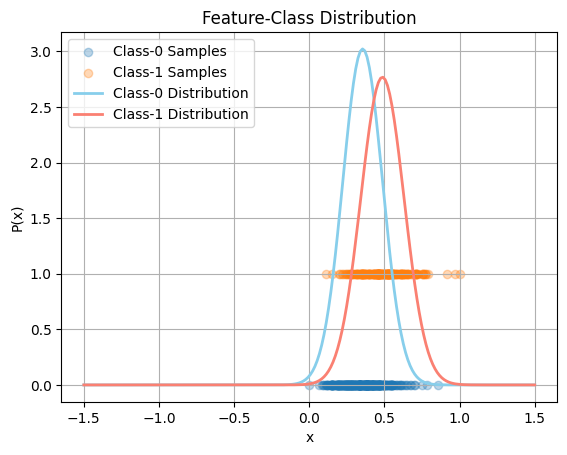

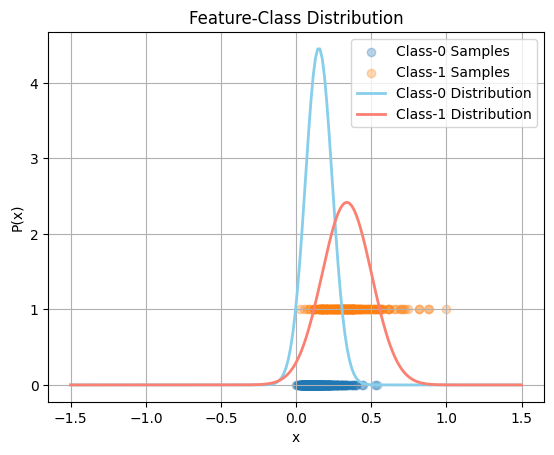

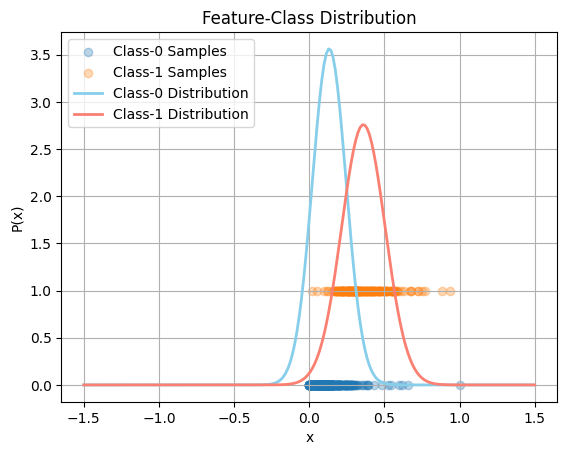

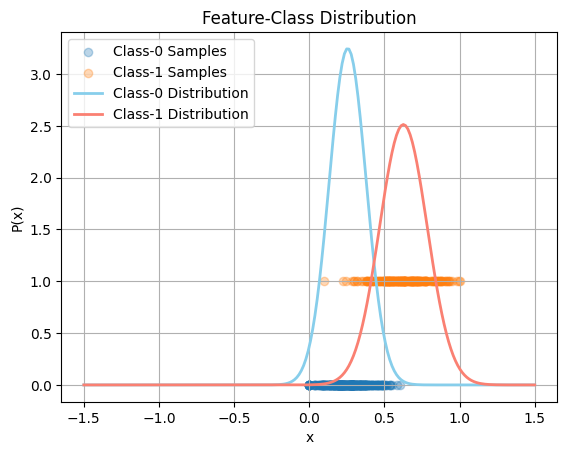

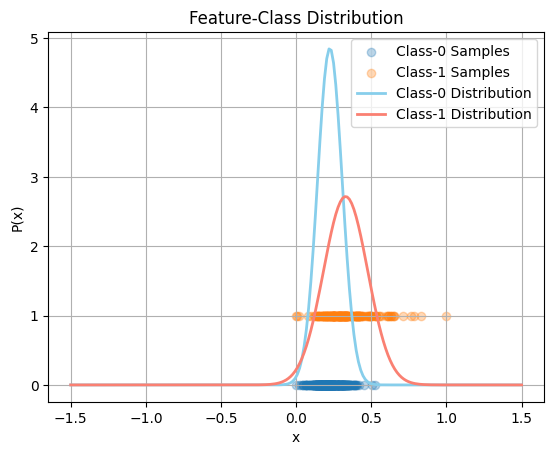

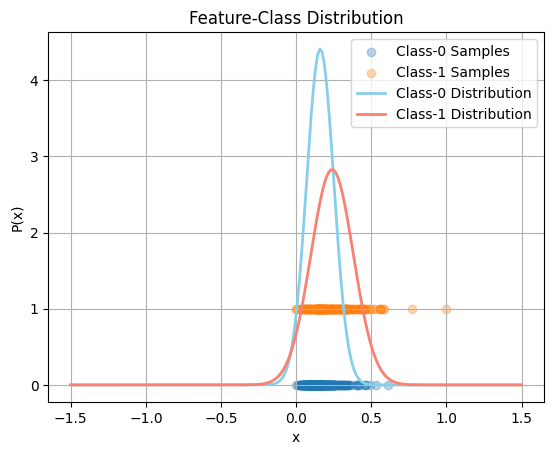

In [309]:
ovr_error = []
mean_diffs = []
x_filt = X
y_filt = y
outlier_limit = 3

def filter_outliers(x_filt, y_filt, p, outlier_limit=3):

    #Filtro de clases
    c0_filt0 = x_filt[y_filt==0]
    c1_filt0 = x_filt[y_filt==1]
    y0_0 = y_filt[y_filt==0]
    y1_0 = y_filt[y_filt==1]

    #Cota inferior
    c0_filt1 = c0_filt0[c0_filt0[:,i]>=(p['mu0'] - p['std0'] * outlier_limit)]
    c1_filt1 = c1_filt0[c1_filt0[:,i]>=(p['mu1'] - p['std1'] * outlier_limit)]
    y0_1 = y0_0[c0_filt0[:,i]>=(p['mu0'] - p['std0'] * outlier_limit)]
    y1_1 = y1_0[c1_filt0[:,i]>=(p['mu1'] - p['std1'] * outlier_limit)]

    #Cota superior
    c0_filt2 = c0_filt1[c0_filt1[:,i]<=(p['mu0'] + p['std0'] * outlier_limit)]
    c1_filt2 = c1_filt1[c1_filt1[:,i]<=(p['mu1'] + p['std1'] * outlier_limit)]

    y0_2 = y0_1[c0_filt1[:,i]<=(p['mu0'] + p['std0'] * outlier_limit)]
    y1_2 = y1_1[c1_filt1[:,i]<=(p['mu1'] + p['std1'] * outlier_limit)]

    # print(f'x: {c0_filt2.shape}; y: {y0_2.shape}')
    # print(f'x: {c1_filt2.shape}; y: {y1_2.shape}')

    x_filt = np.concatenate([c0_filt2, c1_filt2])
    y_filt = np.concatenate([y0_2, y1_2])
    # print(f'x: {x_filt.shape}; y: {y_filt.shape}')

    return x_filt, y_filt



for i in range(X.shape[1]):
    p = get_feature_distribution(X[:,i], y)
    o, m = feature_performance(X[:,i], y,
                        p['mu0'],
                        p['std0'],
                        p['mu1'], 
                        p['std1'],
                        plot=True)
    
    x_filt, y_filt = filter_outliers(x_filt, y_filt, p, 3)
    

    
    ovr_error.append(o)
    mean_diffs.append(m)  
    

Una vez que conocemos los parámetros de cada distribución, podemos aprovecharlos para deshacernos de los outliers parametrizando los filtros en función de la confianza que deseemos integrar en el dataset. En este caso, optaremos por un nivel de confianza del 99.7% y descartaremos cualquier muestra que se localice fuera de los límites: $$\mu \pm 3\times \sigma$$

In [310]:
for i in range(x_filt.shape[1]):
    p = get_feature_distribution(x_filt[:,i], y_filt)
    o, m = feature_performance(x_filt[:,i], y_filt,
                        p['mu0'],
                        p['std0'],
                        p['mu1'], 
                        p['std1'])
    
y = y_filt
X = x_filt

Una vez que cuantificamos las features, nos dirigmos a analizarlas y generar un criterio de selección

In [311]:
print('Feature index\tOverlapping error \t\tMean differences')
print('---------------------------------------------------------------------')
i = 0
for ovr, md in zip(ovr_error, mean_diffs):
    print(f'[{i}]  \t\t{ovr}  \t\t{md}')
    i+=1

Feature index	Overlapping error 		Mean differences
---------------------------------------------------------------------
[0]  		67.72969457749745  		0.2516118310925949
[1]  		65.98314560467132  		0.12479349866809114
[2]  		67.96973751461886  		0.25768759032565525
[3]  		67.75600139312962  		0.2187004110353799
[4]  		65.88930209591143  		0.09407640613175233
[5]  		67.41365388235342  		0.1996906974115957
[6]  		67.26161258727245  		0.26878419862401287
[7]  		67.9924899786876  		0.3095059335861581
[8]  		66.65533348522585  		0.09456044376965567
[9]  		66.36656563252849  		0.003944831894704126
[10]  		66.87186921925695  		0.11768973175036568
[11]  		66.613106261346  		0.002091913322866984
[12]  		66.68322966889538  		0.10948536760908509
[13]  		66.61678778572812  		0.09625971184239314
[14]  		66.50552193763649  		0.014134943099625097
[15]  		66.66786630995416  		0.0814350842351382
[16]  		66.16107110104599  		0.03996786328215296
[17]  		66.296079042485  		0.09855690541861678
[18]  		66.015

La tendencia de los valores de las features aparentemente es lineal, lo cual nos invita a generar una función de regresión. Esta función será útil porque todos los puntos que se encuentren por encima de ella maximizarán la distancia entre las medias de las Gaussianas, o bien, minimizarán el Overlapping Error. Esto funciona como criterio para determinar cuales son las features cuyas distribuciones permiten generar clústeres de datos.

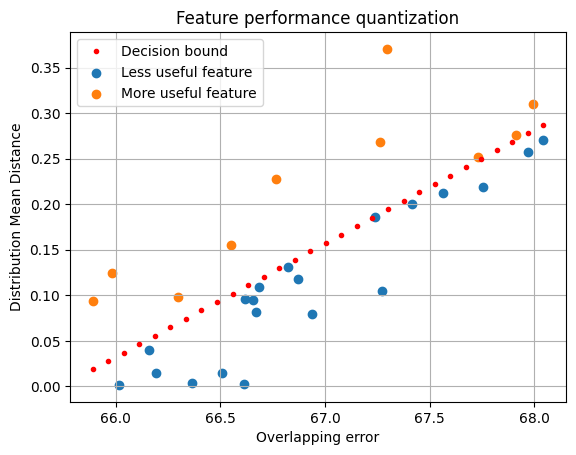

In [312]:
x_axis = np.linspace(np.min(ovr_error), np.max(ovr_error), len(ovr_error))
trending_line = lambda x: 0.1246 * x - 8.1913
bounded_feature = trending_line(np.array(ovr_error))
total_features = 0
for i, e in enumerate(bounded_feature):
    if e - mean_diffs[i] > 0:
        bounded_feature[i] = 1
    else:
        total_features += 1
        bounded_feature[i] = 0

plt.plot(x_axis, trending_line(x_axis),'.r', linewidth=2)
plt.scatter(np.array(ovr_error)[bounded_feature==1], np.array(mean_diffs)[bounded_feature==1])
plt.scatter(np.array(ovr_error)[bounded_feature==0], np.array(mean_diffs)[bounded_feature==0])
plt.legend(['Decision bound', 'Less useful feature', 'More useful feature'], loc='best')
plt.xlabel('Overlapping error')
plt.ylabel('Distribution Mean Distance')
plt.title('Feature performance quantization')
plt.grid(True)

Descartamos las features que se encuentran por debajo de la linea de tendencia, de manera que contaremos con 10/30 dimensiones en nuestro dataset.
Utilizando la información obtenida de las distribuciones, podemos utilizar dichos espacios para realizar un Data Augmentation generando muestras artificiales en función de la distribución correspondiente.
De esta manera, conseguimos un dataset limpio de outliers, con las features más útiles(presúntamente) y con clases balanceadas.

In [313]:
_ = []
for i, bf in enumerate(bounded_feature):
    if bf == 0:
        _.append(X[:,i])
_ = np.array(_).swapaxes(0,1)
X = _
#Data augmentation to solve unbalanced classes
X, y = data_augmentation(X, y)

END DATA ENGINEERING

In [314]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from IPython import display 

In [315]:
X, y = shuffle(X, y)
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.25)

LINEAR CLASSIFIER

In [316]:
class LinearClassifier():
    def __init__(self, dims = 1, bias = 0.0) -> None:
        self.W = np.random.normal(0, 1, dims + 1)
        self.b = bias
        self.loss = (lambda y_true, y_hat: ((y_hat - y_true)**2)/2,
                     lambda y_true, y_hat: (y_hat - y_true))

    def predict(self, input):
        X_ = np.concatenate([np.ones(input.shape[0])[...,np.newaxis], input], axis=1)
        y_hat = X_ @ self.W
        y_hat[y_hat > self.b] = 1
        y_hat[y_hat <= self.b] = 0
        return y_hat

    def update_weights(self, y_true, y_hat, input, lr = 0.01):
        X_ = np.concatenate([np.ones(input.shape[0])[...,np.newaxis], input], axis=1)
        grad = X_.T @ self.loss[1](y_true, y_hat) #Cálculo del gradiente (Derivada de función de costo respecto de los pesos)
        self.W -= grad * lr    #Actualización de pesos (peso actual - gradiente * learning rate)

    def metrics(self, y_true, y_hat):
        y_t = y_hat[y_hat==y_true] #Trues
        y_n = y_hat[y_hat!=y_true] #Negatives

        false_negatives = len(y_n[y_n==0])
        false_positives = len(y_n[y_n==1])
        true_positives = len(y_t[y_t==1])

        recall = true_positives/(true_positives + false_negatives)
        precision = true_positives/(true_positives + false_positives)
        f1 = recall/(precision + recall)


        return (recall, precision, f1)

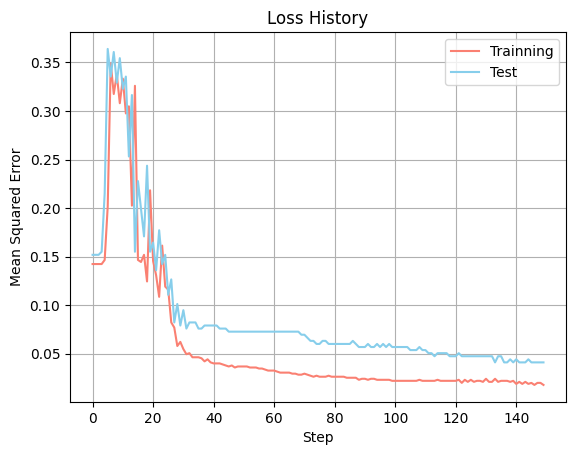

(0.8958333333333334, 0.8431372549019608, 0.5151515151515151)

In [317]:
lc = LinearClassifier(X.shape[1])
loss_train = []
loss_test = []
steps = 150
for i in range(steps):
    display.clear_output(wait=True)
    y_hat = lc.predict(X_train)
    lc.update_weights(y_train, y_hat, X_train, lr = 0.001)
    loss_train.append(np.mean(lc.loss[0](y_train, y_hat)))
    
    y_hat = lc.predict(X_test)
    loss_test.append(np.mean(lc.loss[0](y_test, y_hat)))

    plt.plot(loss_train, color='salmon', label= 'Trainning')
    plt.plot(loss_test, color='skyblue', label= 'Test')
    
    plt.grid(True)
    plt.legend(loc='best')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Step')
    plt.title('Loss History')
    plt.show()
    

lc.metrics(y_test, y_hat)


LOGISTIC CLASSIFIER

In [318]:
class LogisticClassifier():
    def __init__(self, dims = 1, bias = 0.5) -> None:
        self.W = np.random.normal(0, 1, dims + 1)
        self.b = bias
        self.loss = (lambda y, y_hat: ((y_hat - y)**2)/2,
                     lambda y, y_hat: (y_hat - y))
        self.activation = (lambda x: 1/(1 + np.exp(-x)),
                           lambda x: self.activation[0](x) * (1 - self.activation[0](x)))
    

    def predict(self, X, trainning = False):
        X_ = np.concatenate([np.ones(X.shape[0])[...,np.newaxis], X], axis=1)
        z = X_ @ self.W
        y_hat = self.activation[0](z)

        if trainning:
            return y_hat, z
        
        y_hat[y_hat > self.b] = 1
        y_hat[y_hat <= self.b] = 0
        return y_hat


    def update_weights(self, y, z, X, lr = 0.01):
        X_ = np.concatenate([np.ones(X.shape[0])[...,np.newaxis], X], axis=1)
        grad = X_.T @ (self.loss[1](y, y_hat) * self.activation[1](z))
        self.W -= grad * lr

    def metrics(self, y, y_hat):
        y_t = y_hat[y_hat==y] #Trues
        y_n = y_hat[y_hat!=y] #Negatives

        false_negatives = len(y_n[y_n==0])
        false_positives = len(y_n[y_n==1])
        true_positives = len(y_t[y_t==1])

        recall = true_positives/(true_positives + false_negatives)
        precision = true_positives/(true_positives + false_positives)
        f1 = recall/(precision + recall)


        return (recall, precision, f1)


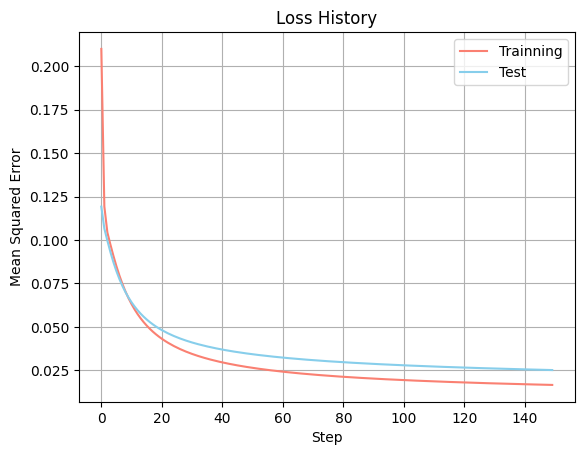

(0.875, 1.0, 0.4666666666666667)

In [319]:
logc = LogisticClassifier(X.shape[1])
loss_train = []
loss_test = []
steps = 150
for i in range(steps):
    display.clear_output(wait=True)
    y_hat, z = logc.predict(X_train, trainning=True)
    logc.update_weights(y_train, z, X_train, lr = 0.02)
    loss_train.append(np.mean(logc.loss[0](y_train, y_hat)))

    y_hat, z = logc.predict(X_test, trainning=True)
    loss_test.append(np.mean(logc.loss[0](y_test, y_hat)))

    plt.plot(loss_train, color='salmon', label= 'Trainning')
    plt.plot(loss_test, color='skyblue', label= 'Test')
    plt.grid(True)
    plt.legend(loc='best')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Step')
    plt.title('Loss History')
    plt.show()
y_hat = logc.predict(X_test)
logc.metrics(y_test, y_hat)